In [1]:
import numpy as np

from seemps.analysis.operators import *
from seemps.state import MPS

from tests.tools import *

class Test_analysis_operators(TestCase):
    n_qubits = 6
    N = 2**n_qubits
    L = 10
    a = - L/2
    dx = L/N
    x = a + dx * np.arange(N)
    k = 2 * np.pi * np.arange(N) / L
    p = k - (np.arange(N) >= (N / 2)) * 2 * np.pi / dx
    f = random_uniform_mps(2, n_qubits)

    def test_id_mpo(self):
        self.assertSimilar(self.f, id_mpo(self.n_qubits) @ self.f)

    def test_x_mpo(self):
        self.assertSimilar(self.x * self.f.to_vector(), x_mpo(self.n_qubits, self.a, self.dx) @ self.f)
    
    def test_x_n_mpo(self):
        n = 3
        self.assertSimilar(self.x**n * self.f.to_vector(), (x_mpo(self.n_qubits, self.a, self.dx) ** n) @ self.f)

    def test_p_mpo(self):
        self.assertSimilar(self.p * self.f.to_vector(), p_mpo(self.n_qubits, self.dx) @ self.f)
    
    def test_p_n_mpo(self):
        n = 3
        self.assertSimilar(self.p**n * self.f.to_vector(), (p_mpo(self.n_qubits, self.dx) ** n) @ self.f)

    def test_exp_mpo(self):
        c = -2j
        self.assertSimilar(np.exp(c*self.x) * self.f.to_vector(), exponential_mpo(self.n_qubits, self.a, self.dx, c) @ self.f)

    def test_cos_mpo(self):
        self.assertSimilar(np.cos(self.x) * self.f.to_vector(), cos_mpo(self.n_qubits, self.a, self.dx) @ self.f)

    def test_sin_mpo(self):
        self.assertSimilar(np.sin(self.x) * self.f.to_vector(), sin_mpo(self.n_qubits, self.a, self.dx) @ self.f)

In [3]:
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.Test_analysis_operators'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_cos_mpo (__main__.Test_analysis_operators.test_cos_mpo) ... ok
test_exp_mpo (__main__.Test_analysis_operators.test_exp_mpo) ... ok
test_id_mpo (__main__.Test_analysis_operators.test_id_mpo) ... ok
test_p_mpo (__main__.Test_analysis_operators.test_p_mpo) ... ok
test_p_n_mpo (__main__.Test_analysis_operators.test_p_n_mpo) ... ok
test_sin_mpo (__main__.Test_analysis_operators.test_sin_mpo) ... ok
test_x_mpo (__main__.Test_analysis_operators.test_x_mpo) ... ok
test_x_n_mpo (__main__.Test_analysis_operators.test_x_n_mpo) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.043s

OK


In [17]:
from seemps import MPO, MPOList, MPSSum, random_uniform_mps
from seemps.operators import MPOSum
from seemps.state import MPSSum
from seemps.state.core import DEFAULT_STRATEGY, Simplification, Strategy, NO_TRUNCATION
from seemps.tools import σx, σy, σz
from seemps.truncate import simplify

from tests.tools import TestCase, contain_same_objects

TEST_STRATEGY = DEFAULT_STRATEGY.replace(simplify=Simplification.VARIATIONAL)


class TestMPOSum(TestCase):
    def setUp(self):
        self.mpoA = MPO([σx.reshape(1, 2, 2, 1)] * 10, strategy=NO_TRUNCATION)
        self.mpoB = MPO([σz.reshape(1, 2, 2, 1)] * 10, strategy=NO_TRUNCATION)
        self.mpoC = MPOList([self.mpoA, self.mpoB], strategy=NO_TRUNCATION)
        self.mpoD = MPO([σy.reshape(1, 2, 2, 1)] * 10, strategy=NO_TRUNCATION)

    def assertIdenticalLists(self, a: list, b: list):
        if not all(A is B for A, B in zip(a, b)):
            raise AssertionError("Different lists:\na = {a}\nb = {b}")

    def test_mposum_init_copies_data(self):
        mpos = [self.mpoA, self.mpoB]
        weights = [1.0, 2.0]
        mposum = MPOSum(mpos, weights)
        self.assertTrue(mposum.mpos is not mpos)
        self.assertTrue(mposum.weights is not weights)

    def test_mposum_copy_is_shallow(self):
        A = MPOSum([self.mpoA, self.mpoB], [1.0, 2.0], Strategy())
        B = A.copy()
        self.assertTrue(A.mpos is not B.mpos)
        self.assertTrue(contain_same_objects(A.mpos, B.mpos))
        self.assertTrue(A.weights is not B.weights)
        self.assertTrue(contain_same_objects(A.weights, B.weights))
        self.assertTrue(A.strategy is B.strategy)

    def test_mposum_simple(self):
        mposum = MPOSum([self.mpoA, self.mpoB])
        self.assertIdenticalLists(mposum.mpos, [self.mpoA, self.mpoB, self.mpoC])
        self.assertSimilar(mposum.weights, [1.0, 1.0])
        self.assertEqual(mposum.size, self.mpoA.size)

    def test_mposum_arises_from_summing_mpos(self):
        mposum = self.mpoA + self.mpoB
        self.assertIsInstance(mposum, MPOSum)
        self.assertIdenticalLists(mposum.mpos, [self.mpoA, self.mpoB])
        self.assertSimilar(mposum.weights, [1.0, 1.0])
        self.assertEqual(mposum.size, self.mpoA.size)

        mposum = self.mpoA + self.mpoC
        self.assertIsInstance(mposum, MPOSum)
        self.assertIdenticalLists(mposum.mpos, [self.mpoA, self.mpoC])
        self.assertSimilar(mposum.weights, [1.0, 1.0])
        self.assertEqual(mposum.size, self.mpoA.size)

        mposum = self.mpoC + self.mpoA
        self.assertIsInstance(mposum, MPOSum)
        self.assertIdenticalLists(mposum.mpos, [self.mpoC, self.mpoA])
        self.assertSimilar(mposum.weights, [1.0, 1.0])
        self.assertEqual(mposum.size, self.mpoA.size)

    def test_mposum_arises_from_subtracting_mpos(self):
        mposum = self.mpoA - self.mpoB
        self.assertIsInstance(mposum, MPOSum)
        self.assertIdenticalLists(mposum.mpos, [self.mpoA, self.mpoB])
        self.assertSimilar(mposum.weights, [1.0, -1.0])

        mposum = self.mpoA - self.mpoC
        self.assertIsInstance(mposum, MPOSum)
        self.assertIdenticalLists(mposum.mpos, [self.mpoA, self.mpoC])
        self.assertSimilar(mposum.weights, [1.0, -1.0])

        mposum = self.mpoC - self.mpoB
        self.assertIsInstance(mposum, MPOSum)
        self.assertIdenticalLists(mposum.mpos, [self.mpoC, self.mpoB])
        self.assertSimilar(mposum.weights, [1.0, -1.0])

    def test_mposum_application_creates_mpssum(self):
        state = random_uniform_mps(2, self.mpoA.size, D=10)

        mposum = self.mpoA + self.mpoB
        newstate = mposum.apply(state, strategy=NO_TRUNCATION)
        self.assertIsInstance(newstate, MPSSum)
        self.assertSimilar(
            (self.mpoA + self.mpoB).apply(state).to_vector(),
            self.mpoA.apply(state).to_vector() + self.mpoB.apply(state).to_vector(),
        )

    def test_mposum_apply_can_simplify(self):
        state = random_uniform_mps(2, self.mpoA.size, D=10)

        mposum = self.mpoA + self.mpoB
        self.assertSimilar(
            (self.mpoA + self.mpoB)
            .apply(state, strategy=TEST_STRATEGY)
            .to_vector(),
            (self.mpoA + self.mpoB).tomatrix() @ state.to_vector(),
        )

    def test_mpo_set_strategy(self):
        new_strategy = Strategy(tolerance=1e-10)
        mposum = (self.mpoA + self.mpoB).set_strategy(new_strategy)
        self.assertTrue(new_strategy, mposum.strategy)

    def test_mposum_application_works_on_mpssum(self):
        mposum = self.mpoA + self.mpoB
        state = random_uniform_mps(2, self.mpoA.size, D=10)
        combined_state = simplify(
            self.mpoA.apply(2 * state) + self.mpoB.apply(2 * state),
            strategy=DEFAULT_STRATEGY.replace(simplify=Simplification.VARIATIONAL),
        )
        self.assertSimilar(mposum.apply(state + state), combined_state)
        self.assertSimilar(mposum @ (state + state), combined_state)

    def test_mposum_join_real_mpos(self):
        state = random_uniform_mps(2, self.mpoA.size, D=10)
        mposum = self.mpoA + self.mpoB
        newstate = mposum @ state
        newstate_join = mposum.join() @ state
        self.assertSimilar(newstate.to_vector(), newstate_join.to_vector())

    def test_mposum_join_complex_mpos(self):
        state = random_uniform_mps(2, self.mpoA.size, D=10)
        mposum = self.mpoA + self.mpoD
        newstate = mposum @ state
        newstate_join = mposum.join() @ state
        self.assertSimilar(newstate.to_vector(), newstate_join.to_vector())

In [18]:
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestMPOSum'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_mpo_set_strategy (__main__.TestMPOSum.test_mpo_set_strategy) ... ok
test_mposum_application_creates_mpssum (__main__.TestMPOSum.test_mposum_application_creates_mpssum) ... ok
test_mposum_application_works_on_mpssum (__main__.TestMPOSum.test_mposum_application_works_on_mpssum) ... ok
test_mposum_apply_can_simplify (__main__.TestMPOSum.test_mposum_apply_can_simplify) ... ok
test_mposum_arises_from_subtracting_mpos (__main__.TestMPOSum.test_mposum_arises_from_subtracting_mpos) ... ok
test_mposum_arises_from_summing_mpos (__main__.TestMPOSum.test_mposum_arises_from_summing_mpos) ... ok
test_mposum_copy_is_shallow (__main__.TestMPOSum.test_mposum_copy_is_shallow) ... ok
test_mposum_init_copies_data (__main__.TestMPOSum.test_mposum_init_copies_data) ... ok
test_mposum_join_complex_mpos (__main__.TestMPOSum.test_mposum_join_complex_mpos) ... ok
test_mposum_join_real_mpos (__main__.TestMPOSum.test_mposum_join_real_mpos) ... ok
test_mposum_simple (__main__.TestMPOSum.test_mposum_simple) ..

In [3]:
import numpy as np
from seemps import MPO, product_state
from seemps.analysis.evolution import *
from seemps.hamiltonians import HeisenbergHamiltonian

from tests.tools import *


def callback():
    norms = []

    def callback_func(state: MPS):
        norms.append(np.sqrt(state.norm_squared()))
        return None

    return callback_func, norms


class TestEuler(TestCase):
    Sz = np.diag([0.5, -0.5])

    def make_local_Sz_mpo(self, size: int) -> MPO:
        A = np.zeros((2, 2, 2, 2))
        A[0, :, :, 0] = np.eye(2)
        A[1, :, :, 1] = np.eye(2)
        A[0, :, :, 1] = self.Sz
        tensors = [A] * size
        tensors[0] = tensors[0][[0], :, :, :]
        tensors[-1] = tensors[-1][:, :, :, [1]]
        return MPO(tensors)

    def test_euler_with_local_field(self):
        N = 4
        H = self.make_local_Sz_mpo(N)
        guess = product_state(np.asarray([1, 1]) / np.sqrt(2.0), N)
        exact = product_state([0, 1], N)
        result = runge_kutta_fehlberg(H, guess, maxiter=100, Δβ=0.05, tol_rk=1e-7)
        self.assertAlmostEqual(result.energy, H.expectation(exact))
        self.assertSimilar(result.state, exact, atol=1e-4)

In [4]:
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestEuler'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_euler_with_local_field (__main__.TestEuler.test_euler_with_local_field) ... 

3.1116426608678096e-19
-0.09991674988386244
-0.199335989140117
-0.29777006697544534
-0.39475063995953225
-0.4898373240469587
-0.582625223830405
-0.7007162386002774
-0.8134885171543358
-0.9329260617979721
-1.0687846860110275
-1.1821698639391012
-1.2876212569805587
-1.3791540836667475
-1.4612079112809053
-1.5357702055962101
-1.6000473714081123
-1.6561916470397575
-1.7059675386609907
-1.7489568330282745
-1.7861813850742314
-1.8187171844610117
-1.846620494799077
-1.87096971887005
-1.891527055509365
-1.9091894308022885
-1.924188693937255
-1.936969080646441
-1.9478085608904194
-1.9570998629197291
-1.9647388894109779
-1.9711824796942305
-1.9764774149569597
-1.9809835304594667
-1.9846236392937473
-1.98766459543858
-1.9901649551361393
-1.9922077982002495
-1.9938435607148408
-1.9952015493697828
-1.996271022671595
-1.9971107328578157
-1.9977876743066731
-1.998314682373921
-1.9987287876466722
-1.9990463089554824
-1.9992901181388114
-1.999477229575199
-1.9996182243029472
-1.9997243520109211
-1.9998

ok

----------------------------------------------------------------------
Ran 1 test in 1.718s

OK


-1.9999999999999996
-2.0
-2.0
-2.0
-1.9999999999999991
-1.9999999999999991
-2.000000000000001
-1.9999999999999996
-2.0
-2.000000000000001


In [3]:
def make_local_Sz_mpo(size: int) -> MPO:
        Sz = np.diag([0.5, -0.5])
        A = np.zeros((2, 2, 2, 2))
        A[0, :, :, 0] = np.eye(2)
        A[1, :, :, 1] = np.eye(2)
        A[0, :, :, 1] = Sz
        tensors = [A] * size
        tensors[0] = tensors[0][[0], :, :, :]
        tensors[-1] = tensors[-1][:, :, :, [1]]
        return MPO(tensors)

In [8]:
N = 4
H = make_local_Sz_mpo(N)
guess = product_state(np.asarray([1, 1]) / np.sqrt(2.0), N)
exact = product_state([0, 1], N)
print('sol =', H.expectation(exact))
result = improved_euler(H, guess)

sol = -2.0


In [8]:
import numpy as np
from seemps.analysis.interpolation import *
from seemps.analysis.space import Space
from seemps.analysis.finite_differences import *
from seemps.state import MPS
from seemps.state.core import DEFAULT_STRATEGY
from tests.tools import *
from tests.tools_interpolation import *


class TestInterpolation(TestCase):
    strategy = DEFAULT_STRATEGY.replace(simplify=2)

    def test_fourier_interpolation_1D(self):
        for n in range(3, 8):
            qubits_per_dimension = [n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2]])
            r_N = get_position_regular_grid(dims, space.a, space.dx)
            sol_N = gaussian(r_N)
            sol_N_mps = MPS.from_vector(
                sol_N, [2] * sum(qubits_per_dimension), normalize=False
            )
            m = n + 2
            M = 2**m
            sol_int = fourier_interpolation_vector_1D(sol_N, M)
            sol_int /= np.linalg.norm(sol_int)
            sol_int_mps, _ = fourier_interpolation_1D(
                sol_N_mps, space, n, m, dim=0, strategy=self.strategy
            )
            self.assertSimilar(sol_int, sol_int_mps)

    def test_fourier_interpolation(self):
        for n in range(3, 8):
            qubits_per_dimension = [n, n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2], [-L / 2, L / 2]])
            r_N = get_position_regular_grid(dims, space.a, space.dx)
            sol_N = gaussian(r_N)
            sol_N_mps = MPS.from_vector(
                sol_N, [2] * sum(qubits_per_dimension), normalize=False
            )
            m = n + 2
            qubits_per_dimension_M = [m, m]
            dims_M = [2**m for m in qubits_per_dimension_M]
            sol_int = fourier_interpolation_vector(sol_N, dims_M)
            sol_int /= np.linalg.norm(sol_int)
            sol_int_mps = fourier_interpolation(
                sol_N_mps,
                space,
                qubits_per_dimension,
                qubits_per_dimension_M,
                strategy=self.strategy,
            )
            self.assertSimilar(sol_int.flatten(), sol_int_mps)

    def test_finite_differences_interpolation_1D(self):
        for n in range(3, 8):
            qubits_per_dimension = [n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2]])
            r_N = get_position_regular_grid(dims, space.a, space.dx)
            sol_N = gaussian(r_N)
            sol_N_mps = MPS.from_vector(
                sol_N, [2] * sum(qubits_per_dimension), normalize=False
            )
            sol_int = interpolate_first_axis(sol_N.reshape(sol_N.shape[0], 1))
            sol_int /= np.linalg.norm(sol_int)
            sol_int_mps, _ = finite_differences_interpolation_1D(
                sol_N_mps, space, strategy=self.strategy
            )
            sol_int_mps = sol_int_mps.to_vector()
            sol_int_mps /= np.linalg.norm(sol_int_mps)
            self.assertSimilar(sol_int.flatten(), sol_int_mps)

    def test_finite_differences_interpolation(self):
        for n in range(3, 8):
            qubits_per_dimension = [n, n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2], [-L / 2, L / 2]])
            r_N = get_position_regular_grid(dims, space.a, space.dx)
            sol_N = gaussian(r_N)
            sol_N_mps = MPS.from_vector(
                sol_N, [2] * sum(qubits_per_dimension), normalize=False
            )
            sol_int = finite_differences_interpolation_vector_2D(sol_N)
            sol_int /= np.linalg.norm(sol_int)
            sol_int_mps = finite_differences_interpolation(
                sol_N_mps, space, strategy=self.strategy
            )
            sol_int_mps = sol_int_mps.to_vector()
            sol_int_mps /= np.linalg.norm(sol_int_mps)
            self.assertSimilar(sol_int.flatten(), sol_int_mps)


In [9]:
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestInterpolation'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_finite_differences_interpolation (__main__.TestInterpolation.test_finite_differences_interpolation) ... ok
test_finite_differences_interpolation_1D (__main__.TestInterpolation.test_finite_differences_interpolation_1D) ... ok
test_fourier_interpolation (__main__.TestInterpolation.test_fourier_interpolation) ... ok
test_fourier_interpolation_1D (__main__.TestInterpolation.test_fourier_interpolation_1D) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.954s

OK


False

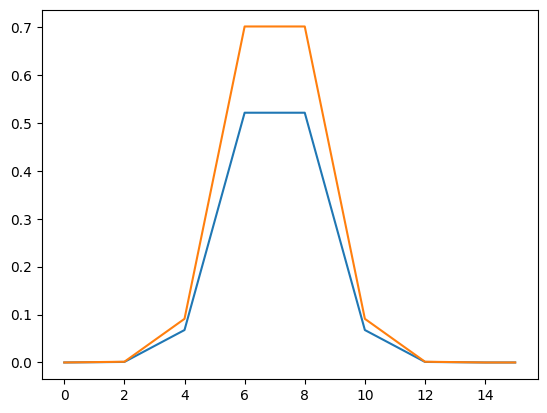

In [7]:
import matplotlib.pyplot as plt
n = 3
qubits_per_dimension = [n]
dims = [2**n for n in qubits_per_dimension]
L = 10
space = Space(qubits_per_dimension, L=[[-L / 2, L / 2]])
r_N = get_position_regular_grid(dims, space.a, space.dx)
sol_N = gaussian(r_N)
sol_N_mps = MPS.from_vector(
    sol_N, [2] * sum(qubits_per_dimension), normalize=False
)
sol_int = interpolate_first_axis(sol_N.reshape(sol_N.shape[0], 1))
sol_int /= np.linalg.norm(sol_int)
sol_int_mps, _ = finite_differences_interpolation_1D(
    sol_N_mps, space, strategy=DEFAULT_STRATEGY.replace(simplify=2)
)
plt.plot(sol_int.flatten())
plt.plot(sol_int_mps.to_vector())

np.allclose(sol_int.flatten(), sol_int_mps.to_vector())

In [46]:
import numpy as np
from seemps.analysis.finite_differences import *
from seemps.analysis.space import Space
from seemps.state import MPS
from seemps.state.core import DEFAULT_STRATEGY, NO_TRUNCATION

from tests.tools import *


def gaussian(x):
    f = np.exp(-(x**2))
    return f / np.linalg.norm(f)


def S_plus_v(n, closed=True):
    S = np.diag(np.ones(2**n - 1), +1)
    if closed:
        S[-1, 0] = 1
    return S


def S_minus_v(n, closed=True):
    S = np.diag(np.ones(2**n - 1), -1)
    if closed:
        S[0, -1] = 1
    return S


def finite_differences_v(n, Δx, closed=True):
    return (1 / Δx**2) * (
        S_plus_v(n, closed=closed) + S_minus_v(n, closed=closed) - 2 * np.eye(2**n)
    )


class TestFiniteDifferences(TestCase):
    def test_finite_differences(self):
        for n in range(2, 10):
            qubits_per_dimension = [n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2]])
            x = space.x[0]
            Δx = space.dx[0]
            v = gaussian(x)
            fd_sol = finite_differences_v(n, Δx, closed=True) @ v
            ψ = MPS.from_vector(v, [2] * n, normalize=False, strategy=NO_TRUNCATION)
            fd_mps_sol = (
                finite_differences_mpo(n, Δx, closed=True, strategy=NO_TRUNCATION) @ ψ
            )
            self.assertSimilar(fd_sol, fd_mps_sol)

In [47]:
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestFiniteDifferences'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_finite_differences (__main__.TestFiniteDifferences.test_finite_differences) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.013s

OK


In [40]:
mpoA = MPO([σx.reshape(1, 2, 2, 1)] * 10)
mpoB = MPO([σz.reshape(1, 2, 2, 1)] * 10)
mposum = mpoA + mpoB
state = random_uniform_mps(2, mpoA.size, D=10)
r1 = mposum.apply(state + state)
r2 = simplify(mpoA.apply(2*state)+mpoB.apply(2*state), strategy=DEFAULT_STRATEGY.replace(simplify=Simplification.VARIATIONAL))
r3 = mposum @ (state + state)

In [41]:
print(r1.to_vector())
print(r2.to_vector())
print(r3.to_vector())

[-6056.91128233  4533.28055751   -79.02661144 ...    79.02661144
 -4533.28055751 -6056.91128233]
[-6056.91128233  4533.28055751   -79.02661144 ...    79.02661144
 -4533.28055751 -6056.91128233]
[-6056.91128233  4533.28055751   -79.02661144 ...    79.02661144
 -4533.28055751 -6056.91128233]
